In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import logging
import os
import random
from collections import Counter
from importlib import reload
import time

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import umap
import scipy

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
import tensorflow as tf
from tensorflow.keras import layers

tf.keras.backend.clear_session()  # For easy reset of notebook state.

# just looking at known markers and trying to disintangle malignant cells

In [59]:
DATA_DIR = '/data/single_cell_classification'
MODEL_DIR = '/models'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_counts_matrix.tsv')
label_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_metadata.tsv')

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

In [60]:
expression_df = pd.read_hdf(expression_fp.replace('.tsv', '.h5'), 'df')
expression_df

Genes,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
HT062B1_S1PA_AAACCCACACAAATGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACCCAGTGCTCCGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACCCATCGGAATTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HT062B1_S1PA_AAACGAACAGCTAACT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACGAAGTAGGGAGG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT110B1_XB3_TTTCATGTCGGCAGTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT110B1_XB3_TTTCCTCGTGTTACTG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HT110B1_XB3_TTTGACTCAGGGTCTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT110B1_XB3_TTTGGAGCAAGAGGCT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
label_df = pd.read_csv(
    label_fp,
    sep=sep
    )
label_df = label_df.set_index('cell_id')
label_df = label_df.loc[expression_df.index]
label_df

,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD8+ T-cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCAGTGCTCCGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Endothelial cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCATCGGAATTC-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAACAGCTAACT-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD4+ T-cells,Homo sapiens,sc,yes
...,...,...,...,...,...,...,...,...
HT110B1_XB3_TTTCATGTCGGCAGTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT110B1_XB3_TTTCCTCGTGTTACTG-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGACTCAGGGTCTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGGAGCAAGAGGCT-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Macrophages,Homo sapiens,sc,yes


In [151]:
adata = anndata.AnnData(X=expression_df.values, obs=label_df)
adata.obs.index = expression_df.index
adata.var.index = expression_df.columns
adata

AnnData object with n_obs × n_vars = 49088 × 33538 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

In [152]:
## get rid of unknowns
adata = adata[adata.obs[cell_type_key]!='Unknown']
adata

View of AnnData object with n_obs × n_vars = 48280 × 33538 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

In [153]:
tumor_adata = adata[adata.obs[cell_type_key]=='BR_Malignant'].copy()
tumor_adata

AnnData object with n_obs × n_vars = 10137 × 33538 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

... storing 'sample_id' as categorical
... storing 'cancer_type' as categorical
... storing 'tissue_type' as categorical
... storing 'organ_type' as categorical
... storing 'cell_type' as categorical
... storing 'species' as categorical
... storing 'method' as categorical
... storing 'facs' as categorical


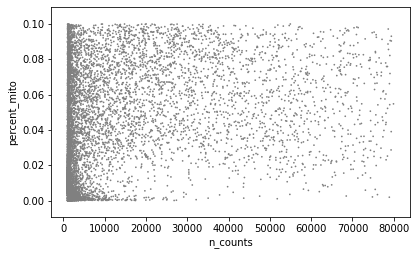

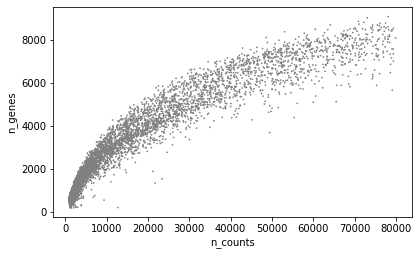

In [154]:
sc.pp.filter_cells(tumor_adata, min_genes=200)
sc.pp.filter_genes(tumor_adata, min_cells=3)

mito_genes = tumor_adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
tumor_adata.obs['percent_mito'] = np.sum(
    tumor_adata[:, mito_genes].X, axis=1) / np.sum(tumor_adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
tumor_adata.obs['n_counts'] = tumor_adata.X.sum(axis=1)

sc.pl.scatter(tumor_adata, x='n_counts', y='percent_mito')
sc.pl.scatter(tumor_adata, x='n_counts', y='n_genes')

In [155]:
sc.pp.normalize_total(tumor_adata, target_sum=1e6)
sc.pp.log1p(tumor_adata)
tumor_adata.raw = tumor_adata
tumor_adata

AnnData object with n_obs × n_vars = 10137 × 23541 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'
    uns: 'log1p'

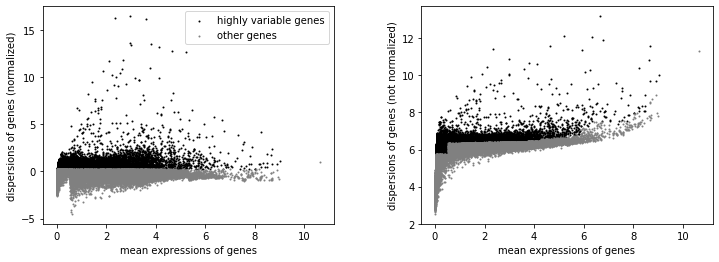

In [156]:
sc.pp.highly_variable_genes(tumor_adata, min_mean=0.0, max_mean=10., min_disp=0.25)
sc.pl.highly_variable_genes(tumor_adata)

In [157]:
np.count_nonzero(tumor_adata.var.highly_variable)

8725

In [158]:
tumor_adata = tumor_adata[:, tumor_adata.var.highly_variable]
sc.pp.scale(tumor_adata, max_value=None)
tumor_adata

/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:909: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 10137 × 8725 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [159]:
sc.tl.pca(tumor_adata, svd_solver='arpack')
sc.pp.neighbors(tumor_adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(tumor_adata)

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


In [160]:
n = 9000

idxs = np.arange(tumor_adata.shape[0])
np.random.shuffle(idxs)

train_idxs = idxs[:n]
val_idxs = idxs[n:]

train_idxs.shape, val_idxs.shape

((9000,), (1137,))

In [161]:
train_adata = tumor_adata[train_idxs, :].copy()
val_adata = tumor_adata[val_idxs, :].copy()

In [162]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
X_train = np.copy(train_adata.X)
X_val = np.copy(val_adata.X)

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train.shape, X_val.shape

((9000, 8725), (1137, 8725))

In [163]:
TRAIN_BUF = 10000
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(X_val).batch(BATCH_SIZE)

In [164]:
class BVAE(tf.keras.Model):
  def __init__(self, latent_dim, input_size):
    super(BVAE, self).__init__()
    self.latent_dim = latent_dim
    self.input_size = input_size
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(input_size,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(input_size),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [165]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x, alpha=0.00005):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  kl_loss = .5 * tf.reduce_sum(tf.exp(logvar) + tf.square(mean) - 1. - logvar, axis=1)
  reconstruction_loss = .5 * tf.reduce_sum(tf.square((x - x_logit)), axis=1)

  overall_loss = tf.reduce_mean(reconstruction_loss + alpha * kl_loss)
  return overall_loss

@tf.function
def compute_apply_gradients(model, x, optimizer, alpha=.00005):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, alpha=alpha)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [166]:
epochs = 50
latent_dim = 100
# alpha = 0.1
alpha = 1.

model = BVAE(latent_dim, X_train.shape[1])

In [167]:
# generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer, alpha=alpha)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x, alpha=alpha))

    print(f'epoch: {epoch}, val loss: {compute_loss(model, next(iter(test_dataset)), alpha)}')

epoch: 1, val loss: 57.42823028564453
epoch: 2, val loss: 55.166072845458984
epoch: 3, val loss: 54.58256912231445
epoch: 4, val loss: 53.89582443237305
epoch: 5, val loss: 54.007598876953125
epoch: 6, val loss: 53.575523376464844
epoch: 7, val loss: 53.76756286621094
epoch: 8, val loss: 53.89717483520508
epoch: 9, val loss: 53.37317657470703
epoch: 10, val loss: 53.291053771972656
epoch: 11, val loss: 53.43695068359375
epoch: 12, val loss: 53.15473175048828
epoch: 13, val loss: 52.95937728881836
epoch: 14, val loss: 52.461639404296875
epoch: 15, val loss: 52.513275146484375
epoch: 16, val loss: 52.09933853149414
epoch: 17, val loss: 52.08924865722656
epoch: 18, val loss: 51.70050811767578
epoch: 19, val loss: 51.744300842285156
epoch: 20, val loss: 51.899009704589844
epoch: 21, val loss: 51.887176513671875
epoch: 22, val loss: 51.57351303100586
epoch: 23, val loss: 51.89851379394531
epoch: 24, val loss: 51.36222839355469
epoch: 25, val loss: 51.4012336730957
epoch: 26, val loss: 51.52

In [168]:
mean, logvar = model.encode(tumor_adata.X)
cell_embeddings = model.reparameterize(mean, logvar).numpy()
cell_embeddings.shape

(10137, 100)

In [169]:
tumor_adata.obsm['cell_embeddings'] = cell_embeddings
tumor_adata.obsm['cell_embedding_umap'] = umap.UMAP().fit_transform(tumor_adata.obsm['cell_embeddings'])
tumor_adata.obs['cell_embedding_umap1'] = tumor_adata.obsm['cell_embedding_umap'][:, 0]
tumor_adata.obs['cell_embedding_umap2'] = tumor_adata.obsm['cell_embedding_umap'][:, 1]

tumor_adata

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


AnnData object with n_obs × n_vars = 10137 × 8725 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts', 'cell_embedding_umap1', 'cell_embedding_umap2'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'cell_embeddings', 'cell_embedding_umap'
    varm: 'PCs'

Less than 100 mammary CSC cells with a phenotype of CD44+, CD24−/low, Lin− were able to generate palpable tumors in NOD/SCID mice, whereas CD44−, CD24+ breast cancer cells, even when injected at 100-fold higher cell densities, were unable to induce tumor formation [50, 56]. Similar results were obtained with breast CSCs expressing CD133+. There was no overlap in CD markers between the CD133+ and the CD44+, CD24− CSCs, but both populations displayed markedly enhanced self-renewal capacity and shared the expression of stemness genes (OCT4, NOTCH1, ALDH1, FGFR1, SOX1)

In [170]:
br_stem_markers = ['CD24', 'ITGB1', 'EPCAM', 'CD44', 'PROM1', 'NCAM1', 'SOX2']

In [177]:
# br_stem_markers = ['CD44', 'CD24', 'LIN28A', 'PROM1', 'POU5F1', 'NOTCH1', 'ALDH1A1', 'FGFR1', 'SOX1']
br_stem_markers = ['CD44', 'CD24', 'LIN28A', 'POU5F1', 'NOTCH1']

In [181]:
for gene in br_stem_markers:
    tups = []
    for i in range(tumor_adata.obsm['X_pca'].shape[1]):
        position_vals = tumor_adata.obsm['X_pca'][:, i].flatten()
        gene_vals = tumor_adata[:, gene].X.flatten()

#         xs, ys = zip(*[(p, g) for p, g, t in zip(position_vals, gene_vals, tumor_adata.obs['dataset'])
#                                                 if t == 'stem'])
        correlation = scipy.stats.pearsonr(position_vals, gene_vals)
        r = correlation[0]
        tups.append((i, r, abs(r)))

        tumor_adata.obs[f'pca_{i}'] = position_vals
    tups = sorted(tups, key=lambda x: x[2], reverse=True)
    print(gene)
    print(tups[:5])


CD44
[(2, 0.3827623687518334, 0.3827623687518334), (0, 0.13919887181109478, 0.13919887181109478), (4, -0.10959423061758901, 0.10959423061758901), (6, 0.07912837775374021, 0.07912837775374021), (29, 0.06737267004955484, 0.06737267004955484)]
CD24
[(1, -0.4450862845699901, 0.4450862845699901), (3, -0.20358279310837366, 0.20358279310837366), (0, 0.16310171877680377, 0.16310171877680377), (5, 0.15035710872894448, 0.15035710872894448), (11, 0.13953294626157284, 0.13953294626157284)]
LIN28A
[(31, -0.03649166764184402, 0.03649166764184402), (45, -0.02936740669014218, 0.02936740669014218), (27, 0.025342693423909043, 0.025342693423909043), (39, 0.023081671600952015, 0.023081671600952015), (20, 0.02251231284022469, 0.02251231284022469)]
POU5F1
[(0, 0.08558145714875412, 0.08558145714875412), (2, 0.07056985382461432, 0.07056985382461432), (6, -0.06985845750090433, 0.06985845750090433), (22, 0.05830559695710579, 0.05830559695710579), (16, 0.051402286933981516, 0.051402286933981516)]
NOTCH1
[(0, 0.3

In [178]:
for gene in br_stem_markers:
    tups = []
    for i in range(tumor_adata.obsm['cell_embeddings'].shape[1]):
        position_vals = tumor_adata.obsm['cell_embeddings'][:, i].flatten()
        gene_vals = tumor_adata[:, gene].X.flatten()

#         xs, ys = zip(*[(p, g) for p, g, t in zip(position_vals, gene_vals, tumor_adata.obs['dataset'])
#                                                 if t == 'stem'])
        correlation = scipy.stats.pearsonr(position_vals, gene_vals)
        r = correlation[0]
        tups.append((i, r, abs(r)))

        tumor_adata.obs[f'position_{i}'] = position_vals
    tups = sorted(tups, key=lambda x: x[2], reverse=True)
    print(gene)
    print(tups[:5])


CD44
[(49, -0.26732926292641956, 0.26732926292641956), (11, -0.24555036055685792, 0.24555036055685792), (94, -0.23043432057702248, 0.23043432057702248), (17, 0.2276298505767702, 0.2276298505767702), (79, 0.22140265268323242, 0.22140265268323242)]
CD24
[(68, 0.313149695043612, 0.313149695043612), (57, 0.27166288363389746, 0.27166288363389746), (81, -0.2017531150932695, 0.2017531150932695), (70, 0.19310858159169175, 0.19310858159169175), (95, 0.18868823564894474, 0.18868823564894474)]
LIN28A
[(87, 0.03674597602532094, 0.03674597602532094), (36, -0.0299768753681992, 0.0299768753681992), (31, -0.026329527733924264, 0.026329527733924264), (30, 0.023821779223906766, 0.023821779223906766), (34, 0.02271488266483345, 0.02271488266483345)]
POU5F1
[(81, -0.08516714280817178, 0.08516714280817178), (30, -0.07280391312085942, 0.07280391312085942), (49, -0.07166972080968112, 0.07166972080968112), (94, -0.07117999072089999, 0.07117999072089999), (19, -0.06950642788476605, 0.06950642788476605)]
NOTCH1


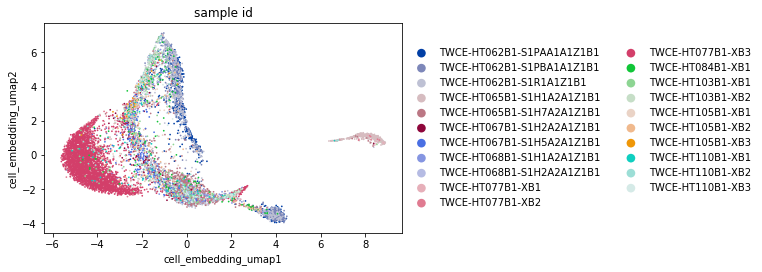

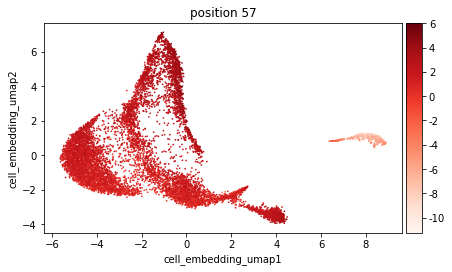

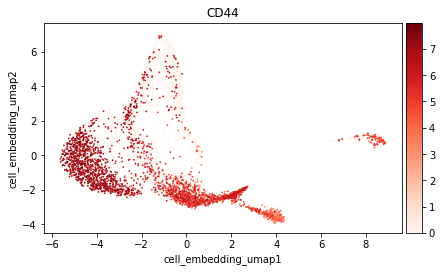

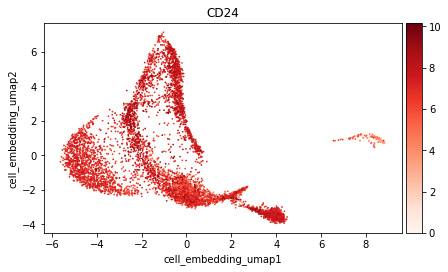

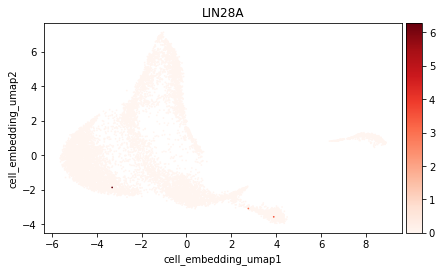

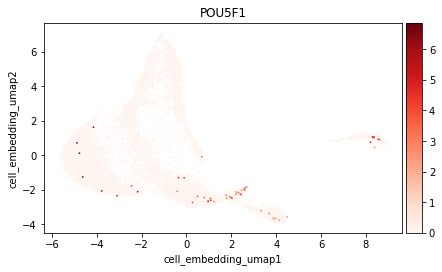

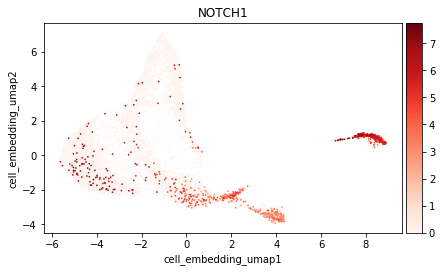

In [180]:
variables = ['sample_id', 'position_57']
variables += br_stem_markers
for var in variables:
    sc.pl.scatter(tumor_adata, x='cell_embedding_umap1', y='cell_embedding_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()

In [ ]:
sc.pl.umap(tumor_adata, color=variables, frameon=False, ncols=1, color_map='Reds')

# integration with single cell stem dataset

In [3]:
expression_fp = '/data/stemness/ERP016000/counts.tsv'
metadata_fp = '/data/stemness/ERP016000/cell_metadata_cols.tsv'

In [4]:
expression_df = pd.read_hdf(expression_fp.replace('.tsv', '.hd5'), 'df')
expression_df.index = [c.split('_')[-1] for c in expression_df.index]
expression_df = expression_df.transpose()
expression_df

,TSPAN6,DPM1,SCYL3,C1orf112,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,...,LUC7L2,ZNF559-ZNF177,HSPE1-MOB4,RPS10-NUDT3,SRGAP2D,MTRNR2L2,SRXN1,GTF2H5,NUDT3,CD24
21843_1#10,5.520777,5.392461,0.000174,1.471928,2.908802,0.127185,0.000000,3.615650,0.000000,5.604953,...,0.575989,0.290480,3.342019,2.955039,0.286690,8.993125,0.000000,1.397666,0.716015,2.578313
21843_1#100,6.456208,6.065923,0.352597,4.536968,3.867327,0.047614,4.277551,0.000000,0.000000,5.848853,...,1.379352,0.000000,2.642681,0.315327,0.446590,10.310311,0.000000,1.399811,1.857059,0.000000
21843_1#101,5.878671,6.838769,0.000000,4.318528,3.321747,4.042388,0.000000,2.545334,0.185345,5.196831,...,3.051514,0.000000,3.053322,1.082602,0.000000,10.112632,0.390075,2.421133,2.499615,0.889010
21843_1#102,4.860824,6.614268,0.825955,5.373009,3.736476,2.662104,1.115943,0.000000,0.000000,3.811312,...,2.453614,0.000000,2.503949,2.271033,0.000000,9.380978,0.000000,2.250520,2.615108,1.963302
21843_1#103,5.903640,6.512403,2.201697,4.636175,4.917576,2.499359,2.278948,2.672572,0.243054,4.964217,...,1.613052,0.000000,2.471723,0.218927,0.000000,9.511378,0.000000,2.633359,1.682406,1.412966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24539_8#93,6.199875,5.885993,0.000000,3.227508,4.221847,0.000000,4.137042,1.758011,0.000000,5.039266,...,1.130735,1.937917,1.906042,1.143744,0.000000,1.709041,0.000000,3.208027,2.139444,7.552773
24539_8#94,7.014180,7.431358,0.108025,2.621121,3.188030,1.393474,3.378998,3.703450,0.139112,4.209373,...,0.403450,1.756385,5.584232,1.768525,0.410279,7.568684,0.000000,4.137374,0.852408,7.631217
24539_8#95,6.228476,7.013124,1.756339,3.950978,4.741496,2.465067,3.069041,2.829073,4.306653,5.019318,...,0.474118,0.279475,5.136851,0.203189,1.306076,6.345048,0.284224,1.847985,1.091890,7.109529
24539_8#97,6.217161,4.851771,2.492943,3.926914,3.872743,3.189254,2.178870,1.834021,0.000000,4.075990,...,1.440802,2.394519,3.511525,1.622543,0.000000,7.577899,0.000000,2.144427,2.796956,7.185068


In [5]:
metadata_df = pd.read_csv(metadata_fp, sep='\t')
metadata_df = metadata_df.loc[expression_df.index]
metadata_df = metadata_df[['assigned', 'cell_name', 'day', 'donor_long_id', 'donor_short_id', 'experiment',
                          'total_counts', 'total_counts_MT', 'pseudo', 'sample_id', 'well_id', 'well_type']]
metadata_df

,assigned,cell_name,day,donor_long_id,donor_short_id,experiment,total_counts,total_counts_MT,pseudo,sample_id,well_id,well_type
21843_1#10,1,21843_1#10,day1,HPSI0114i-joxm_1,joxm_1,expt_09,598658.209173,45560.066753,0.292682,21843_1#10,A10,single cell
21843_1#100,1,21843_1#100,day1,HPSI0314i-fafq_1,fafq_1,expt_09,222558.809077,26617.964539,0.484716,21843_1#100,E04,single cell
21843_1#101,1,21843_1#101,day1,HPSI0314i-fafq_1,fafq_1,expt_09,582661.572985,55173.613380,0.403809,21843_1#101,E05,single cell
21843_1#102,1,21843_1#102,day1,HPSI1013i-wuye_2,wuye_2,expt_09,476557.701340,37076.110494,0.260772,21843_1#102,E06,single cell
21843_1#103,1,21843_1#103,day1,HPSI0114i-joxm_1,joxm_1,expt_09,404342.711311,28949.266469,0.355366,21843_1#103,E07,single cell
...,...,...,...,...,...,...,...,...,...,...,...,...
24539_8#93,1,24539_8#93,day1,HPSI0713i-nocf_2,nocf_2,expt_35,347580.461936,31633.724898,0.199677,24539_8#93,D21,single cell
24539_8#94,1,24539_8#94,day1,HPSI1013i-zagm_1,zagm_1,expt_35,395735.359197,56999.061471,0.251769,24539_8#94,D22,single cell
24539_8#95,1,24539_8#95,day1,HPSI0314i-wigw_2,wigw_2,expt_35,474715.299368,37026.549761,0.226935,24539_8#95,D23,single cell
24539_8#97,1,24539_8#97,day1,HPSI1113i-wahn_1,wahn_1,expt_35,75472.999850,4251.880902,0.389748,24539_8#97,E01,single cell


In [6]:
stem_adata = anndata.AnnData(X=expression_df.values, obs=metadata_df)
stem_adata.obs.index = expression_df.index
stem_adata.var.index = expression_df.columns
stem_adata

AnnData object with n_obs × n_vars = 36044 × 11231 
    obs: 'assigned', 'cell_name', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'total_counts', 'total_counts_MT', 'pseudo', 'sample_id', 'well_id', 'well_type'

In [7]:
DATA_DIR = '/data/single_cell_classification'
MODEL_DIR = '/models'

run_name = 'br'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_counts_matrix.tsv')
label_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_metadata.tsv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

n_per_cell_type = 5000
epochs = 5
batch_size = 128

In [8]:
expression_df = pd.read_hdf(expression_fp.replace('.tsv', '.h5'), 'df')
expression_df

Genes,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
HT062B1_S1PA_AAACCCACACAAATGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACCCAGTGCTCCGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACCCATCGGAATTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HT062B1_S1PA_AAACGAACAGCTAACT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACGAAGTAGGGAGG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT110B1_XB3_TTTCATGTCGGCAGTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT110B1_XB3_TTTCCTCGTGTTACTG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HT110B1_XB3_TTTGACTCAGGGTCTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT110B1_XB3_TTTGGAGCAAGAGGCT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
label_df = pd.read_csv(
    label_fp,
    sep=sep
    )
label_df = label_df.set_index('cell_id')
label_df = label_df.loc[expression_df.index]
label_df

,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD8+ T-cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCAGTGCTCCGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Endothelial cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCATCGGAATTC-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAACAGCTAACT-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD4+ T-cells,Homo sapiens,sc,yes
...,...,...,...,...,...,...,...,...
HT110B1_XB3_TTTCATGTCGGCAGTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT110B1_XB3_TTTCCTCGTGTTACTG-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGACTCAGGGTCTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGGAGCAAGAGGCT-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Macrophages,Homo sapiens,sc,yes


In [10]:
tumor_adata = anndata.AnnData(X=expression_df.values, obs=label_df)
tumor_adata.obs.index = expression_df.index
tumor_adata.var.index = expression_df.columns
tumor_adata

AnnData object with n_obs × n_vars = 49088 × 33538 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

In [11]:
## get rid of unknowns
tumor_adata = tumor_adata[tumor_adata.obs[cell_type_key]!='Unknown']
tumor_adata

View of AnnData object with n_obs × n_vars = 48280 × 33538 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

Trying to set attribute `.obs` of view, copying.
... storing 'sample_id' as categorical
... storing 'cancer_type' as categorical
... storing 'tissue_type' as categorical
... storing 'organ_type' as categorical
... storing 'cell_type' as categorical
... storing 'species' as categorical
... storing 'method' as categorical
... storing 'facs' as categorical


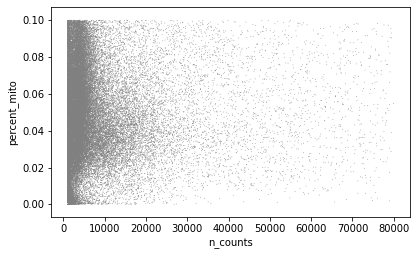

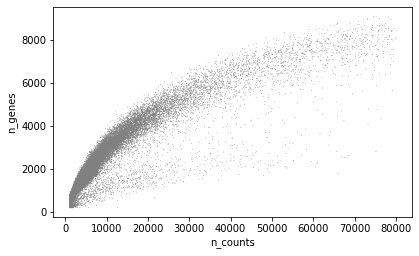

In [12]:
sc.pp.filter_cells(tumor_adata, min_genes=200)
sc.pp.filter_genes(tumor_adata, min_cells=3)

mito_genes = tumor_adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
tumor_adata.obs['percent_mito'] = np.sum(
    tumor_adata[:, mito_genes].X, axis=1) / np.sum(tumor_adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
tumor_adata.obs['n_counts'] = tumor_adata.X.sum(axis=1)

sc.pl.scatter(tumor_adata, x='n_counts', y='percent_mito')
sc.pl.scatter(tumor_adata, x='n_counts', y='n_genes')

In [13]:
## stem dataset is cpm then logged so do the same thing here
sc.pp.normalize_total(tumor_adata, target_sum=1e6)
sc.pp.log1p(tumor_adata)
tumor_adata.raw = tumor_adata
tumor_adata

AnnData object with n_obs × n_vars = 48280 × 26912 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'
    uns: 'log1p'

In [14]:
stem_adata.raw = stem_adata

In [ ]:
## bring in the stem dataset

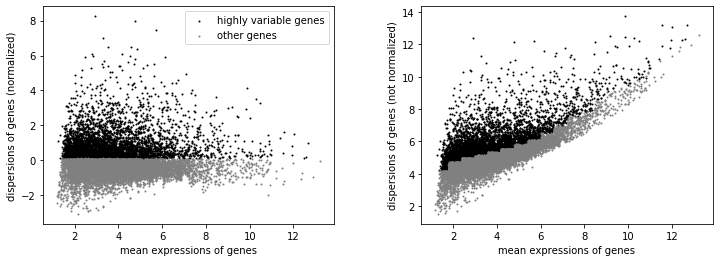

In [15]:
sc.pp.highly_variable_genes(stem_adata, min_mean=0.0, max_mean=15., min_disp=0.1)
sc.pl.highly_variable_genes(stem_adata)

In [16]:
np.count_nonzero(stem_adata.var.highly_variable)

4134

In [17]:
## just go ahead and keep everything that overlaps
adata = stem_adata.concatenate(tumor_adata)
adata

AnnData object with n_obs × n_vars = 84324 × 10520 
    obs: 'assigned', 'batch', 'cancer_type', 'cell_name', 'cell_type', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'facs', 'method', 'n_counts', 'n_genes', 'organ_type', 'percent_mito', 'pseudo', 'sample_id', 'species', 'tissue_type', 'total_counts', 'total_counts_MT', 'well_id', 'well_type'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1'

In [18]:
# adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=None)
adata

AnnData object with n_obs × n_vars = 84324 × 10520 
    obs: 'assigned', 'batch', 'cancer_type', 'cell_name', 'cell_type', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'facs', 'method', 'n_counts', 'n_genes', 'organ_type', 'percent_mito', 'pseudo', 'sample_id', 'species', 'tissue_type', 'total_counts', 'total_counts_MT', 'well_id', 'well_type'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1'

In [19]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/utils.py", line 409:
@numba.njit(p

In [20]:
adata.obs['dataset'] = ['stem' if pd.isnull(x) else 'tumor' for x in adata.obs['cell_type']]

In [21]:
n = 2500

stem_idxs = np.asarray(adata.obs.index)[adata.obs['dataset']=='stem']
np.random.shuffle(stem_idxs)

stem_train_idxs = stem_idxs[:n]
stem_val_idxs = stem_idxs[n:]

stem_train_idxs.shape, stem_val_idxs.shape

((2500,), (33544,))

In [22]:
import random
## filter smartly
n = 2500

ta = adata[adata.obs['cell_type']=='BR_Malignant']


cell_type_to_idxs = {}
for cell_id, cell_type in zip(ta.obs.index, ta.obs[cell_type_key]):
    if cell_type not in cell_type_to_idxs:
        cell_type_to_idxs[cell_type] = [cell_id]
    else:
        cell_type_to_idxs[cell_type].append(cell_id)
        
def temp(ls):
    if len(ls) > n:
        return random.sample(ls, n)
    return random.sample(ls, int(len(ls) * .8))

cell_type_to_idxs = {k:temp(ls)
                     for k, ls in cell_type_to_idxs.items()}

tumor_train_idxs = np.asarray([x for ls in cell_type_to_idxs.values() for x in ls])
tumor_train_idxs = np.arange(ta.shape[0])[np.isin(np.asarray(ta.obs.index), tumor_train_idxs)]
tumor_val_idxs = np.delete(np.arange(ta.shape[0]), tumor_train_idxs)

tumor_train_idxs = np.asarray([ta.obs.index[i] for i in tumor_train_idxs])
tumor_val_idxs = np.asarray([ta.obs.index[i] for i in tumor_val_idxs])


tumor_train_idxs.shape, tumor_val_idxs.shape

((2500,), (7637,))

In [23]:
train_idxs = np.concatenate((stem_train_idxs, tumor_train_idxs))
np.random.shuffle(train_idxs)

val_idxs = np.concatenate((stem_val_idxs, tumor_val_idxs))
np.random.shuffle(val_idxs)

train_idxs.shape, val_idxs.shape

((5000,), (41181,))

In [24]:
train_adata = adata[train_idxs, :].copy()
val_adata = adata[val_idxs, :].copy()

In [25]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
X_train = np.copy(train_adata.X)
X_val = np.copy(val_adata.X)

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train.shape, X_val.shape

((5000, 10520), (41181, 10520))

In [26]:
TRAIN_BUF = 10000
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(X_val).batch(BATCH_SIZE)

In [27]:
class BVAE(tf.keras.Model):
  def __init__(self, latent_dim, input_size):
    super(BVAE, self).__init__()
    self.latent_dim = latent_dim
    self.input_size = input_size
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(input_size,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(input_size),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [28]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x, alpha=0.00005):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  kl_loss = .5 * tf.reduce_sum(tf.exp(logvar) + tf.square(mean) - 1. - logvar, axis=1)
  reconstruction_loss = .5 * tf.reduce_sum(tf.square((x - x_logit)), axis=1)

  overall_loss = tf.reduce_mean(reconstruction_loss + alpha * kl_loss)
  return overall_loss

@tf.function
def compute_apply_gradients(model, x, optimizer, alpha=.00005):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, alpha=alpha)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [29]:
epochs = 50
latent_dim = 50
alpha = 0.1

model = BVAE(latent_dim, X_train.shape[1])

In [30]:
# generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer, alpha=alpha)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x, alpha=alpha))

    print(f'epoch: {epoch}, val loss: {compute_loss(model, next(iter(test_dataset)), alpha)}')

epoch: 1, val loss: 218.6092529296875
epoch: 2, val loss: 211.97303771972656
epoch: 3, val loss: 205.83404541015625
epoch: 4, val loss: 202.560791015625
epoch: 5, val loss: 201.6902618408203
epoch: 6, val loss: 199.8963623046875
epoch: 7, val loss: 197.87893676757812
epoch: 8, val loss: 196.71612548828125
epoch: 9, val loss: 195.6609649658203
epoch: 10, val loss: 194.06735229492188
epoch: 11, val loss: 195.30718994140625
epoch: 12, val loss: 192.5488739013672
epoch: 13, val loss: 191.96597290039062
epoch: 14, val loss: 193.1931610107422
epoch: 15, val loss: 191.677734375
epoch: 16, val loss: 190.1025390625
epoch: 17, val loss: 190.42706298828125
epoch: 18, val loss: 189.67373657226562
epoch: 19, val loss: 189.1952362060547
epoch: 20, val loss: 189.80999755859375
epoch: 21, val loss: 188.49227905273438
epoch: 22, val loss: 188.22268676757812
epoch: 23, val loss: 188.0802001953125
epoch: 24, val loss: 188.15802001953125
epoch: 25, val loss: 189.45144653320312
epoch: 26, val loss: 187.213

In [31]:
p_adata = train_adata.concatenate(val_adata)
p_adata

AnnData object with n_obs × n_vars = 46181 × 10520 
    obs: 'assigned', 'batch', 'cancer_type', 'cell_name', 'cell_type', 'dataset', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'facs', 'method', 'n_counts', 'n_genes', 'organ_type', 'percent_mito', 'pseudo', 'sample_id', 'species', 'tissue_type', 'total_counts', 'total_counts_MT', 'well_id', 'well_type'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1'
    obsm: 'X_pca', 'X_umap'

In [32]:
cell_embeddings = None
step = 1000
for i in range(0, p_adata.shape[0], step):
    batch = p_adata[i:i+step]
    
    mean, logvar = model.encode(batch.X)
    if cell_embeddings is None:
        cell_embeddings = model.reparameterize(mean, logvar).numpy()
    else:
        cell_embeddings = np.concatenate((cell_embeddings, model.reparameterize(mean, logvar).numpy()),
                                         axis=0)

cell_embeddings.shape

(46181, 50)

In [33]:
p_adata.obsm['cell_embeddings'] = cell_embeddings
p_adata

AnnData object with n_obs × n_vars = 46181 × 10520 
    obs: 'assigned', 'batch', 'cancer_type', 'cell_name', 'cell_type', 'dataset', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'facs', 'method', 'n_counts', 'n_genes', 'organ_type', 'percent_mito', 'pseudo', 'sample_id', 'species', 'tissue_type', 'total_counts', 'total_counts_MT', 'well_id', 'well_type'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1'
    obsm: 'X_pca', 'X_umap', 'cell_embeddings'

In [34]:
p_adata.obsm['cell_embedding_umap'] = umap.UMAP().fit_transform(p_adata.obsm['cell_embeddings'])
p_adata.obs['cell_embedding_umap1'] = p_adata.obsm['cell_embedding_umap'][:, 0]
p_adata.obs['cell_embedding_umap2'] = p_adata.obsm['cell_embedding_umap'][:, 1]

p_adata

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/nndescent.py", line 47:
    @

AnnData object with n_obs × n_vars = 46181 × 10520 
    obs: 'assigned', 'batch', 'cancer_type', 'cell_name', 'cell_type', 'dataset', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'facs', 'method', 'n_counts', 'n_genes', 'organ_type', 'percent_mito', 'pseudo', 'sample_id', 'species', 'tissue_type', 'total_counts', 'total_counts_MT', 'well_id', 'well_type', 'cell_embedding_umap1', 'cell_embedding_umap2'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1'
    obsm: 'X_pca', 'X_umap', 'cell_embeddings', 'cell_embedding_umap'

... storing 'cancer_type' as categorical
... storing 'cell_name' as categorical
... storing 'cell_type' as categorical
... storing 'dataset' as categorical
... storing 'day' as categorical
... storing 'donor_long_id' as categorical
... storing 'donor_short_id' as categorical
... storing 'experiment' as categorical
... storing 'facs' as categorical
... storing 'method' as categorical
... storing 'organ_type' as categorical
... storing 'sample_id' as categorical
... storing 'species' as categorical
... storing 'tissue_type' as categorical
... storing 'well_id' as categorical
... storing 'well_type' as categorical


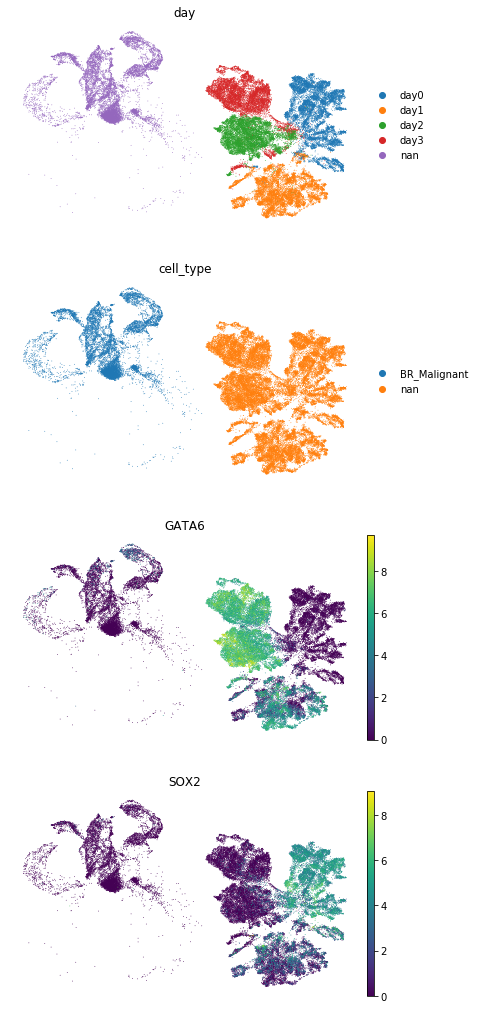

In [35]:
sc.pl.umap(p_adata, color=['day', 'cell_type', 'GATA6', 'SOX2'], frameon=False, ncols=1, )

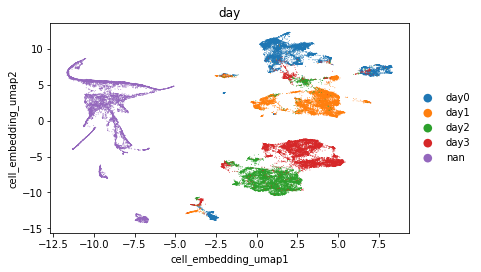

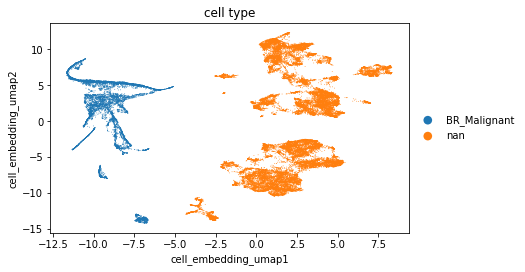

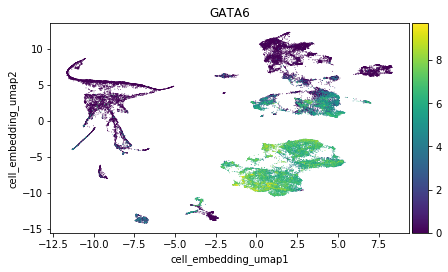

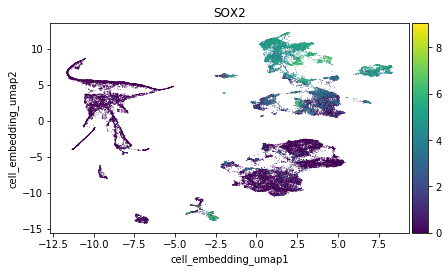

In [36]:
variables = ['day', 'cell_type', 'GATA6', 'SOX2']
for var in variables:
    sc.pl.scatter(p_adata, x='cell_embedding_umap1', y='cell_embedding_umap2', color=var,
                 frameon=False)
    plt.show()

In [ ]:
## https://www.cell.com/trends/molecular-medicine/fulltext/S1471-4914(08)00162-7

In [56]:
br_stem_markers = ['CD24', 'ITGB1', 'EPCAM', 'CD44', 'PROM1', 'NCAM1']

In [55]:
gene = 'CD34'
idx = list(p_adata.var.index).index(gene)
gene, idx

ValueError: 'CD34' is not in list

In [57]:
for gene in br_stem_markers:
    tups = []
    for i in range(p_adata.obsm['cell_embeddings'].shape[1]):
        position_vals = p_adata.obsm['cell_embeddings'][:, i].flatten()
        gene_vals = p_adata[:, gene].X.flatten()

        xs, ys = zip(*[(p, g) for p, g, t in zip(position_vals, gene_vals, p_adata.obs['dataset'])
                                                if t == 'stem'])
        correlation = scipy.stats.pearsonr(xs, ys)
        r = correlation[0]
        tups.append((i, r, abs(r)))

        p_adata.obs[f'position_{i}'] = position_vals
    tups = sorted(tups, key=lambda x: x[2], reverse=True)
    print(gene)
    print(tups[:5])


CD24
[(2, -0.3738553090371421, 0.3738553090371421), (41, -0.34771821320807855, 0.34771821320807855), (32, -0.267927903740959, 0.267927903740959), (8, 0.26290287272188395, 0.26290287272188395), (38, 0.25984697023266723, 0.25984697023266723)]
ITGB1
[(0, -0.3651233161201439, 0.3651233161201439), (42, 0.3241434942970985, 0.3241434942970985), (35, 0.31947241267536947, 0.31947241267536947), (31, 0.3011762194960725, 0.3011762194960725), (12, 0.2710895894328548, 0.2710895894328548)]
EPCAM
[(22, 0.5340730618830292, 0.5340730618830292), (16, 0.5050695568907969, 0.5050695568907969), (12, -0.5011761430370311, 0.5011761430370311), (42, -0.4549948165353329, 0.4549948165353329), (44, 0.45257142745815787, 0.45257142745815787)]
CD44
[(44, 0.22346876665080864, 0.22346876665080864), (49, -0.19341047535030512, 0.19341047535030512), (7, 0.17827383788387882, 0.17827383788387882), (37, -0.17694113026348415, 0.17694113026348415), (0, 0.17234305712631134, 0.17234305712631134)]
PROM1
[(12, -0.5327175884818267, 

In [39]:
p_adata.obs['sample_name'] = ['stem' if d == 'stem' else s
                              for d, s in zip(p_adata.obs['dataset'], p_adata.obs['sample_id'])]
# set(p_adata.obs['sample_name'])

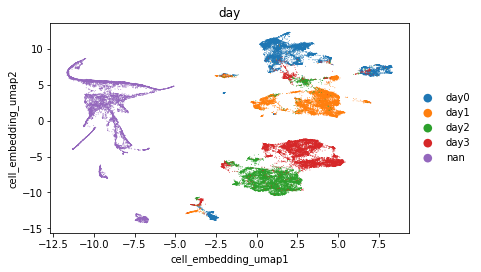

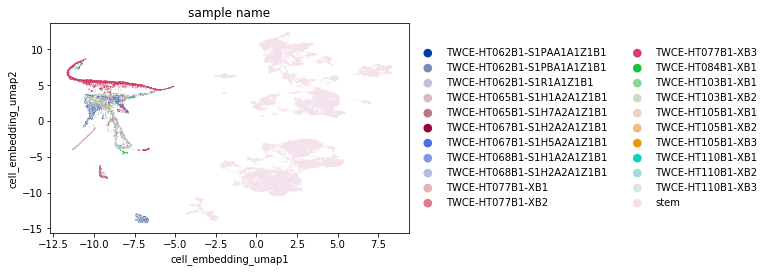

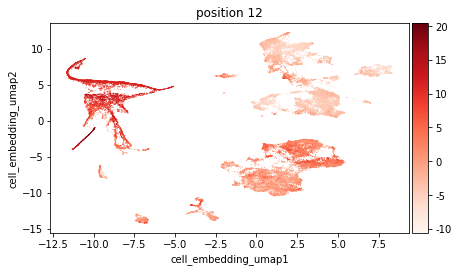

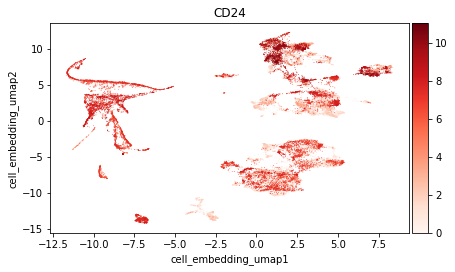

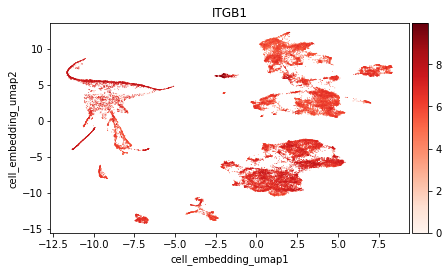

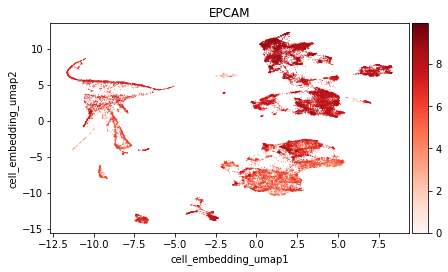

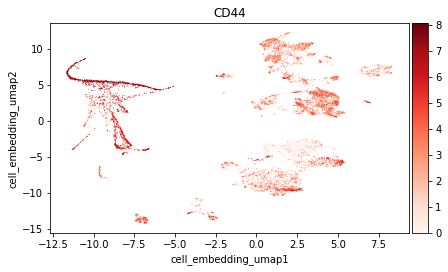

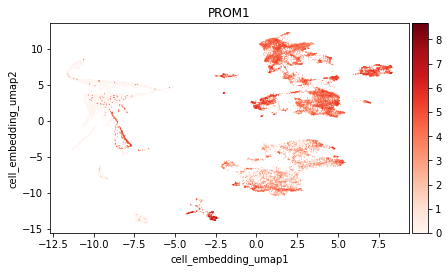

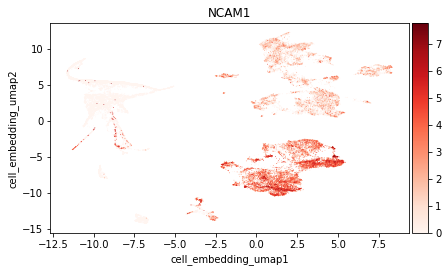

In [58]:
variables = ['day', 'sample_name', 'position_12']
variables += br_stem_markers
for var in variables:
    sc.pl.scatter(p_adata, x='cell_embedding_umap1', y='cell_embedding_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()